In [1]:
import torch
# 数据的原始处理
from torchvision import transforms
# pytorch十分贴心的为我们直接准备了这个数据集
from torchvision import datasets
# 加载数据集的
from torch.utils.data import DataLoader
# 激活函数
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# 准备数据
 
batch_size = 64
#我们拿到的图片是pillow,我们要把他转换成模型里能训练的tensor也就是张量的格式
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
 
train_dataset = datasets.MNIST(root='../dataset/mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = datasets.MNIST(root='../dataset/mnist/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [5]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        # 输入通道=输出通道        
        self.conv1 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        # 避免梯度接近0,grad = grad +1        
        return F.relu(x + y)
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5)
        self.mp = torch.nn.MaxPool2d(2)
        self.rblock1 = ResidualBlock(16)
        self.rblock2 = ResidualBlock(32)
        self.fc = torch.nn.Linear(512, 10)
    def forward(self, x):
        in_size = x.size(0)
        # 1x28x28 -> 16x24x24 -> 16x12x12        
        x = self.mp(F.relu(self.conv1(x)))
        # 16x12x12 -> 16x12x12        
        x = self.rblock1(x)
        # 16x12x12 -> 32x8x8 -> 32x4x4        
        x = self.mp(F.relu(self.conv2(x)))
        # 32x4x4 -> 32x4x4        
        x = self.rblock2(x)
        x = x.view(in_size, -1)
        # 全链接 512 -> 10        
        x = self.fc(x)
        return x
model = Net()
# 把计算迁移到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rblock1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rblock2): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [6]:
# 构造损失和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)# lr为学习率

[1,   300] loss: 0.485
[1,   600] loss: 0.137
[1,   900] loss: 0.107
accuracy on test set: 97 % 
[2,   300] loss: 0.081
[2,   600] loss: 0.075
[2,   900] loss: 0.066
accuracy on test set: 98 % 
[3,   300] loss: 0.056
[3,   600] loss: 0.052
[3,   900] loss: 0.054
accuracy on test set: 98 % 
[4,   300] loss: 0.045
[4,   600] loss: 0.044
[4,   900] loss: 0.045
accuracy on test set: 98 % 
[5,   300] loss: 0.041
[5,   600] loss: 0.037
[5,   900] loss: 0.036
accuracy on test set: 98 % 
[6,   300] loss: 0.034
[6,   600] loss: 0.034
[6,   900] loss: 0.033
accuracy on test set: 98 % 
[7,   300] loss: 0.033
[7,   600] loss: 0.030
[7,   900] loss: 0.026
accuracy on test set: 99 % 
[8,   300] loss: 0.023
[8,   600] loss: 0.030
[8,   900] loss: 0.029
accuracy on test set: 99 % 
[9,   300] loss: 0.026
[9,   600] loss: 0.023
[9,   900] loss: 0.023
accuracy on test set: 98 % 
[10,   300] loss: 0.019
[10,   600] loss: 0.023
[10,   900] loss: 0.023
accuracy on test set: 99 % 


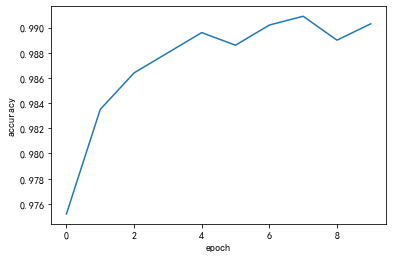

In [7]:
# 训练
 
 
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        #  正馈        
        outputs = model(inputs)
        loss = criterion(outputs, target)
        # 反馈        
        loss.backward()
        # 更新权重         
        optimizer.step()
        # 把损失加起来         
        running_loss += loss.item()
        #每300次输出一下数据
        if batch_idx % 300 == 299:
            print('[%d, %5d] loss: %.3f' % (epoch+1, batch_idx+1, running_loss/300))
            running_loss = 0.0
 
# 测试集

def test():
    correct = 0
    total = 0
    #不用算梯度    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # 我们取概率最大的那个数作为输出            
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('accuracy on test set: %d %% ' % (100*correct/total))
    return correct/total
 
 
if __name__ == '__main__':
    epoch_list = []
    acc_list = []
    
    for epoch in range(10):
        train(epoch)
        acc = test()
        epoch_list.append(epoch)
        acc_list.append(acc)
    
    plt.plot(epoch_list,acc_list)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()